# Exemplo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from ipywidgets import interact, FloatLogSlider

## Explorando os dados

https://github.com/ageron/handson-ml2/tree/master/datasets/housing

In [2]:
df = pd.read_csv('https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observamos:
- O atributo `total_bedrooms` possui dados faltantes
- O atributo `ocean_proximity` é categórico

In [4]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

<Axes: ylabel='ocean_proximity'>

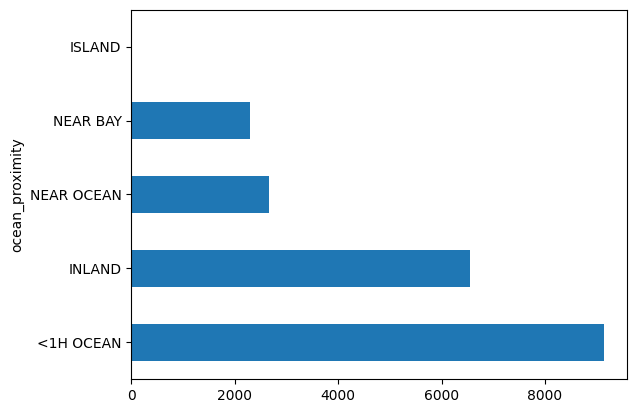

In [5]:
#df['ocean_proximity'].value_counts().plot(kind='bar')
df['ocean_proximity'].value_counts().plot(kind='barh')

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

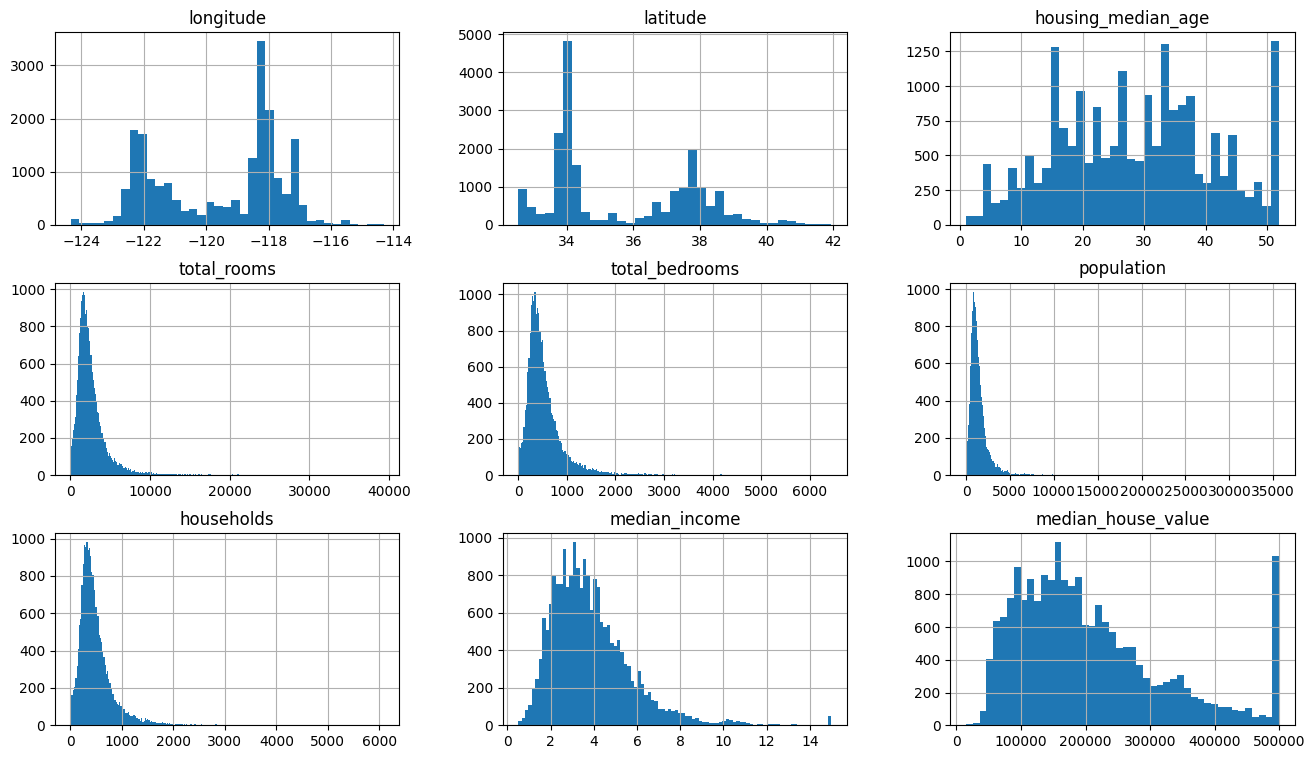

In [6]:
# note: this shows only numeric features
df.hist(bins='auto', figsize=(16,9), layout=(3,3))

**Pergunta:** O que podemos concluir analisando esses histogramas?

### Limpando os dados

In [7]:
df['median_house_value'].value_counts().sort_index(ascending=False).head()

median_house_value
500001.0    965
500000.0     27
499100.0      1
499000.0      1
498800.0      1
Name: count, dtype: int64

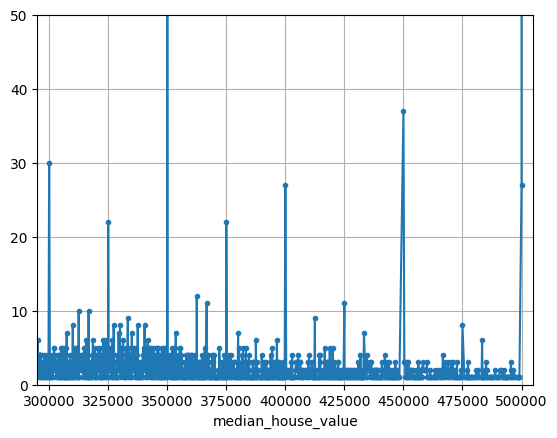

In [8]:
df['median_house_value'].value_counts().sort_index().plot(style='.-')
plt.xlim(295000, 505000)
plt.ylim(0, 50)
plt.grid()

In [9]:
len(df[df['median_house_value'] <= 500000])/len(df)

0.9532461240310077

Organizando o código:

In [10]:
df = pd.read_csv('https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.csv')
df = df[df['median_house_value'] <= 500000]  # this implies that the model should not be trusted for predictions > 500000
print(df.shape)

(19675, 10)


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

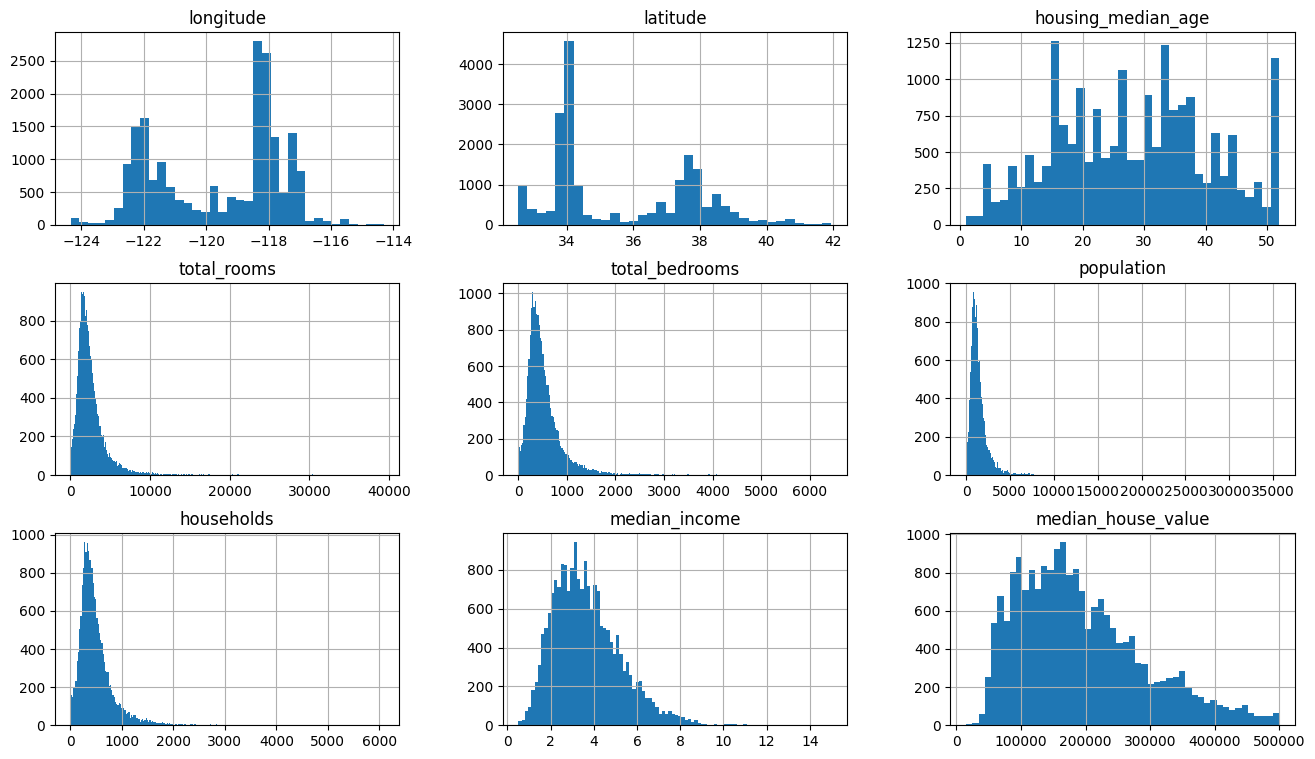

In [11]:
df.hist(bins='auto', figsize=(16,9), layout=(3,3))

## Definindo a métrica de avaliação

In [12]:
df['median_house_value'].describe()

count     19675.000000
mean     192477.921017
std       97711.509613
min       14999.000000
25%      116600.000000
50%      173800.000000
75%      248200.000000
max      500000.000000
Name: median_house_value, dtype: float64

In [13]:
df['median_house_value'].min()/df['median_house_value'].max()

0.029998

- O MAE pode fazer sentido numa aplicação em que pretendemos fazer predições para vários imóveis e estamos preocupados com a soma total dos erros absolutos (em USD) entre valor real e predito, não importando se o erro for para mais ou para menos.
- Porém, numa aplicação que desejamos estimar o preço de um imóvel para recomendar a um cliente e a opinião de cada cliente sobre o serviço tem o mesmo impacto independente do valor do imóvel, então o mais adequado seria usar uma métrica de erro relativo, como o MAPE.
- O RMSE dificilmente faria sentido em alguma aplicação, porém é a perda otimizada por padrão em modelos de regressão linear (mínimos quadrados).

In [14]:
root_mean_squared_error = lambda a, b: np.sqrt(np.mean((a - b)**2))
from sklearn.metrics import mean_absolute_percentage_error

## Particionando em treino e teste

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=3)
print(df_train.shape, df_test.shape)

(15740, 10) (3935, 10)


<Axes: >

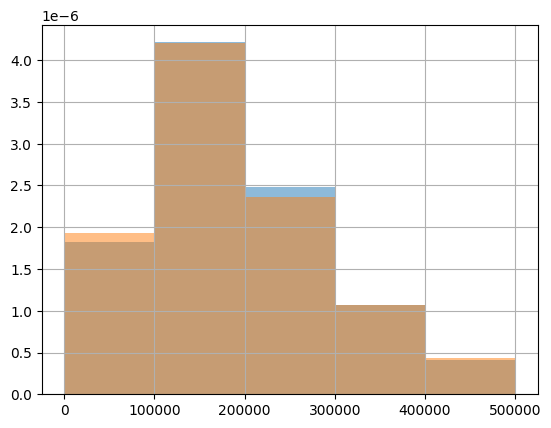

In [16]:
bins = np.arange(6)*100000
df['median_house_value'].hist(bins=bins, density=True, alpha=0.5)
df_test['median_house_value'].hist(bins=bins, density=True, alpha=0.5)

price_cat
0    0.185921
1    0.420483
2    0.247675
3    0.106328
4    0.039593
Name: proportion, dtype: float64

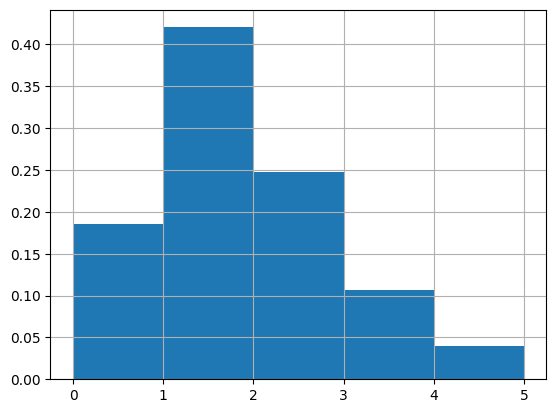

In [17]:
df['price_cat'] = pd.cut(df['median_house_value'], bins=np.arange(6)*100000, labels=range(5))
df['price_cat'].hist(bins=range(6), density=True)
df['price_cat'].value_counts(sort=False, normalize=True)

In [18]:
random_state = 3
_, df_test_random = train_test_split(df, test_size=0.2, stratify=None, random_state=random_state)
_, df_test_stratified = train_test_split(df, test_size=0.2, stratify=df['price_cat'], random_state=random_state)

proportions = pd.DataFrame(columns=['Overall', 'Random', 'Stratified'])
for i, d in enumerate([df, df_test_random, df_test_stratified]):
    proportions.iloc[:, i] = d['price_cat'].value_counts(sort=False, normalize=True)
proportions['Random (% error)'] = 100*np.abs(proportions['Random']/proportions['Overall'] - 1)
proportions['Stratified (% error)'] = 100*np.abs(proportions['Stratified']/proportions['Overall'] - 1)
proportions

,Overall,Random,Stratified,Random (% error),Stratified (% error)
price_cat,,,,,
0,0.185921,0.196696,0.186023,5.795517,0.054675
1,0.420483,0.419568,0.42033,0.217575,0.036263
2,0.247675,0.234816,0.247776,5.191874,0.041042
3,0.106328,0.106226,0.106226,0.095602,0.095602
4,0.039593,0.042694,0.039644,7.830552,0.12837


In [19]:
print(df.shape)
df.columns

(19675, 11)


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'price_cat'],
      dtype='object')

Para mostrar esse exemplo foi adicionada uma coluna `price_cat` que deve agora ser removida, então é melhor refazer do zero.

Organizando o código -- e aproveitando para já separar `X` e `y`:

In [20]:
df = pd.read_csv('https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.csv')
df = df[df['median_house_value'] <= 500000]
price_cat = pd.cut(df['median_house_value'], bins=np.arange(6)*100000, labels=range(5))
df_train, df_test = train_test_split(df, test_size=0.2, stratify=price_cat, random_state=3)
del df  # avoid using by mistake
print(df_train.shape)
print(df_test.shape)

target = 'median_house_value'
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]
print(X_train.shape, y_train.shape)

X_test = df_test.drop(target, axis=1)
y_test = df_test[target]
print(X_test.shape, y_test.shape)

## Alternatively:
# X = df.drop(target, axis=1)
# y = df[target]
# df_train, df_test, X_train, X_test, y_train, y_test = train_test_split(df, X, y, test_size=0.2, stratify=price_cat, random_state=3)
# del df, X, y

(15740, 10)
(3935, 10)
(15740, 9) (15740,)
(3935, 9) (3935,)


## Análise exploratória

- Uma vez particionados os dados, toda análise a partir de agora será feita **somente com o conjunto de treinamento**.
- Agora podemos correlacionar as variáveis de entrada com a variável-alvo.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

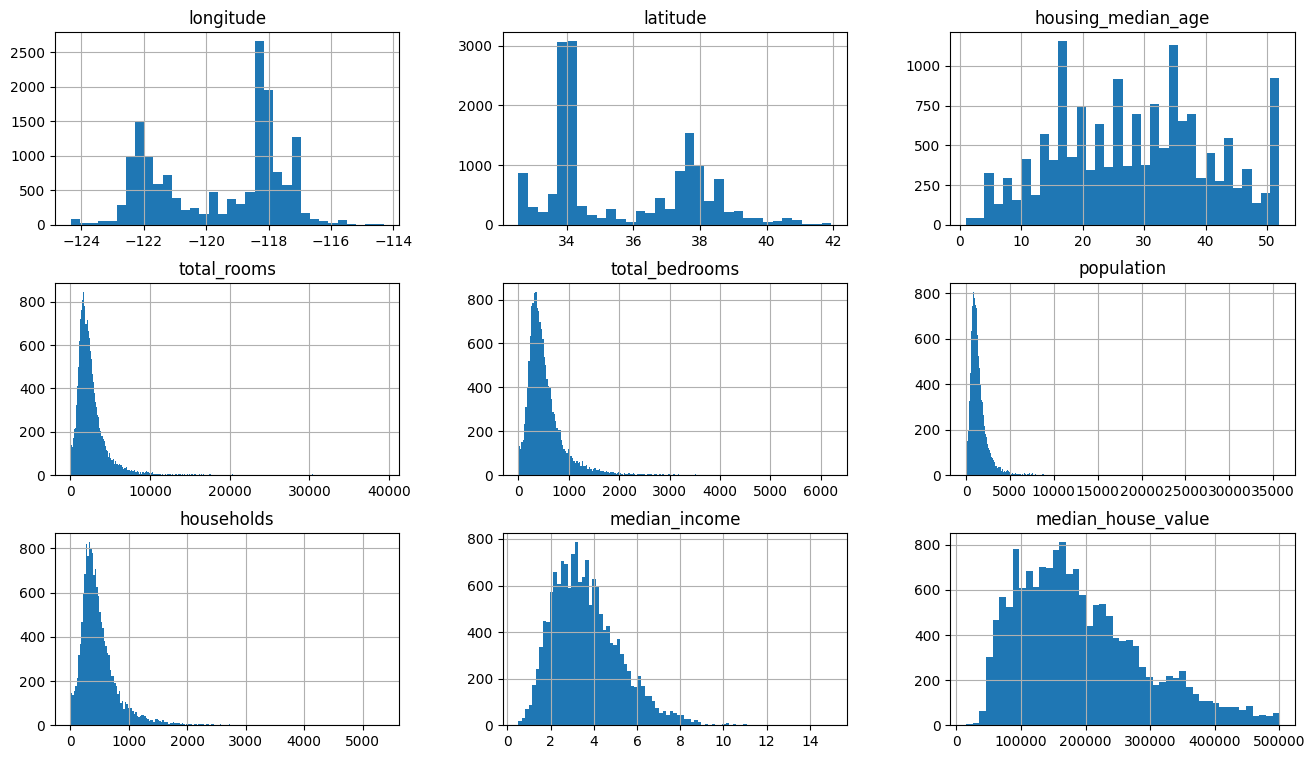

In [21]:
df_train.hist(bins='auto', figsize=(16,9), layout=(3,3))

In [22]:
df_train['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     6858
INLAND        5266
NEAR OCEAN    1936
NEAR BAY      1676
ISLAND           4
Name: count, dtype: int64

#### Exercício
Usando somente os dados de treinamento:
1. Encontre o atributo mais correlacionado com `median_house_value`
2. Encontre os dois atributos mais correlacionados entre si
3. Trace um gráfico de barras com o valor médio de `median_house_value` para cada categoria de `ocean_proximity` (dica: utilize `pd.groupby()`)

#### Solução

In [44]:
from sklearn.preprocessing import LabelEncoder

# Supondo que 'categoria_col' seja a coluna com valores categóricos
label_encoder = LabelEncoder()
df_train_encoded = df_train.copy()
df_train_encoded['ocean_proximity'] = label_encoder.fit_transform(df_train_encoded['ocean_proximity'])

# Agora calcule a correlação
corr = df_train_encoded.corr()

In [46]:
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.639908
total_rooms           0.144813
households            0.096094
total_bedrooms        0.075417
housing_median_age    0.071873
ocean_proximity       0.068766
categoria_col         0.068766
population            0.012967
longitude            -0.048182
latitude             -0.147507
Name: median_house_value, dtype: float64

<Axes: >

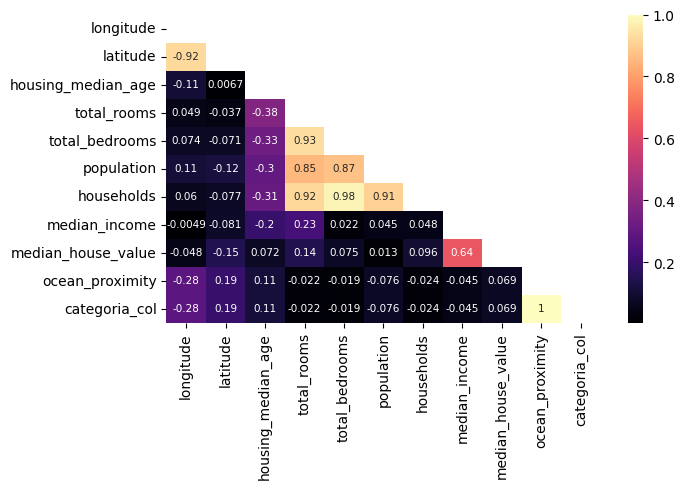

In [50]:
import seaborn as sns
plt.figure(figsize=(7,4))
sns.heatmap(corr.abs(), annot=corr,  annot_kws={"size": 7.5}, mask=np.triu(np.ones_like(corr)), cmap='magma')

In [51]:
df_train.groupby('ocean_proximity')['median_house_value'].mean()

ocean_proximity
<1H OCEAN     223951.895596
INLAND        123543.656855
ISLAND        371875.000000
NEAR BAY      238092.422434
NEAR OCEAN    228635.278926
Name: median_house_value, dtype: float64

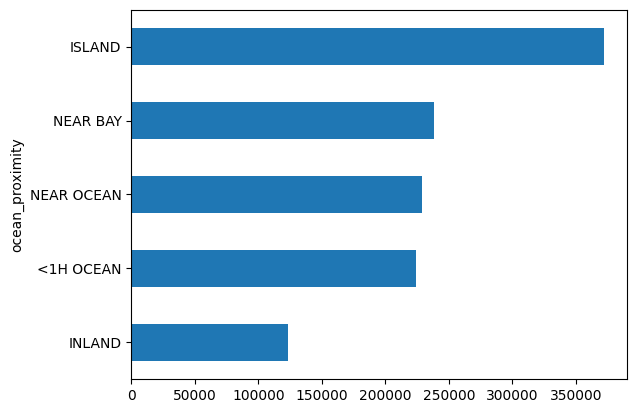

In [52]:
df_train.groupby('ocean_proximity')['median_house_value'].mean().sort_values().plot(kind='barh');

## Lidando com atributos categóricos

In [53]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
ocean_encoded = ordinal_encoder.fit_transform(df_train[['ocean_proximity']])
print(ordinal_encoder.categories_)
print({i: ordinal_encoder.inverse_transform([[i]])[0][0] for i in range(5)})
pd.Series(ocean_encoded.reshape(-1)).value_counts()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
{0: '<1H OCEAN', 1: 'INLAND', 2: 'ISLAND', 3: 'NEAR BAY', 4: 'NEAR OCEAN'}


0.0    6858
1.0    5266
4.0    1936
3.0    1676
2.0       4
Name: count, dtype: int64

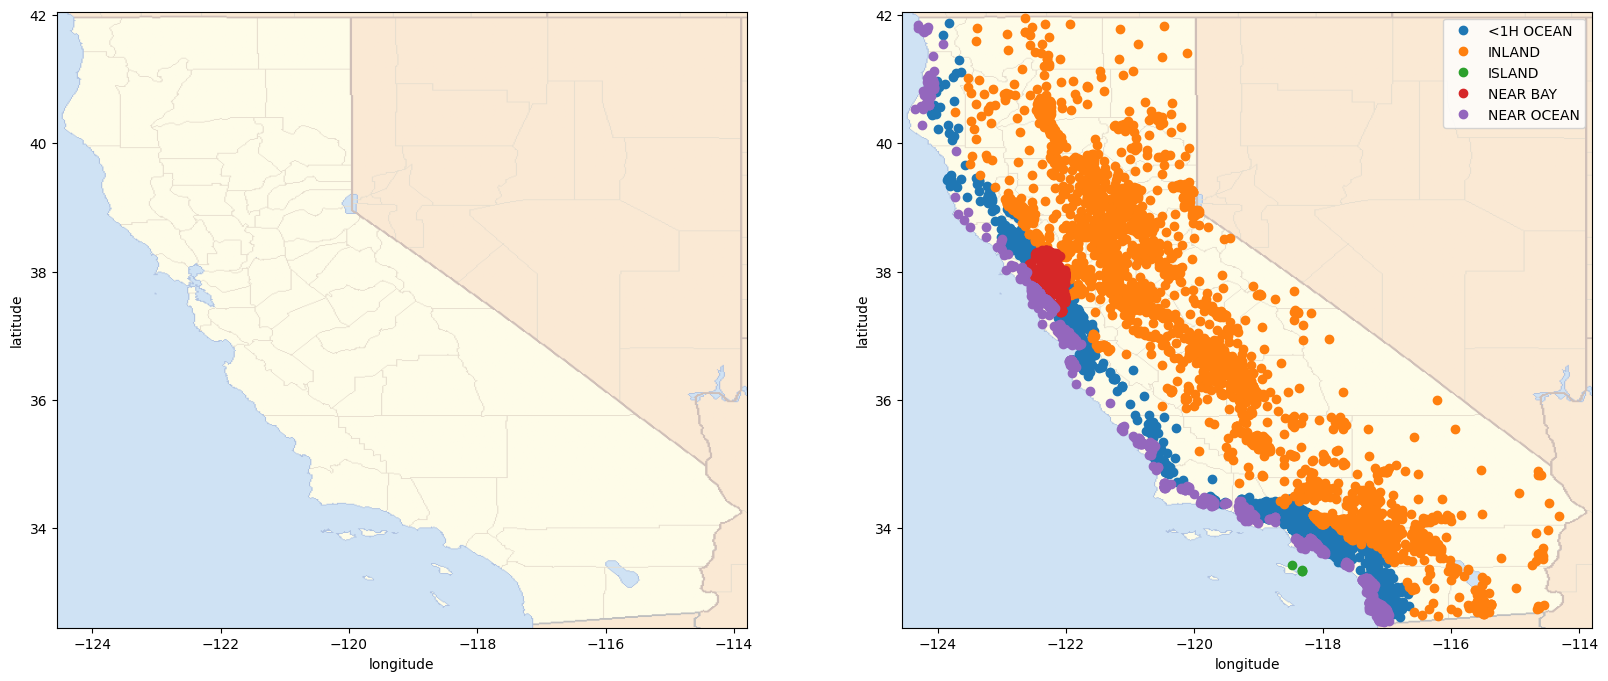

In [54]:
import urllib
import io
url = 'https://github.com/ageron/handson-ml2/raw/master/images/end_to_end_project/california.png'
california_img = plt.imread(io.BytesIO(urllib.request.urlopen(url).read()))
## Alternative:
# import skimage
# california_img = skimage.io.imread(url)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel('longitude'); plt.ylabel('latitude')
plt.subplot(1,2,2)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel('longitude'); plt.ylabel('latitude')
for a in sorted(df_train['ocean_proximity'].unique()):
#for a in ['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']:
    idx = df_train['ocean_proximity'] == a
    plt.plot(df_train['longitude'][idx], df_train['latitude'][idx], 'o', label=a)
    plt.legend()

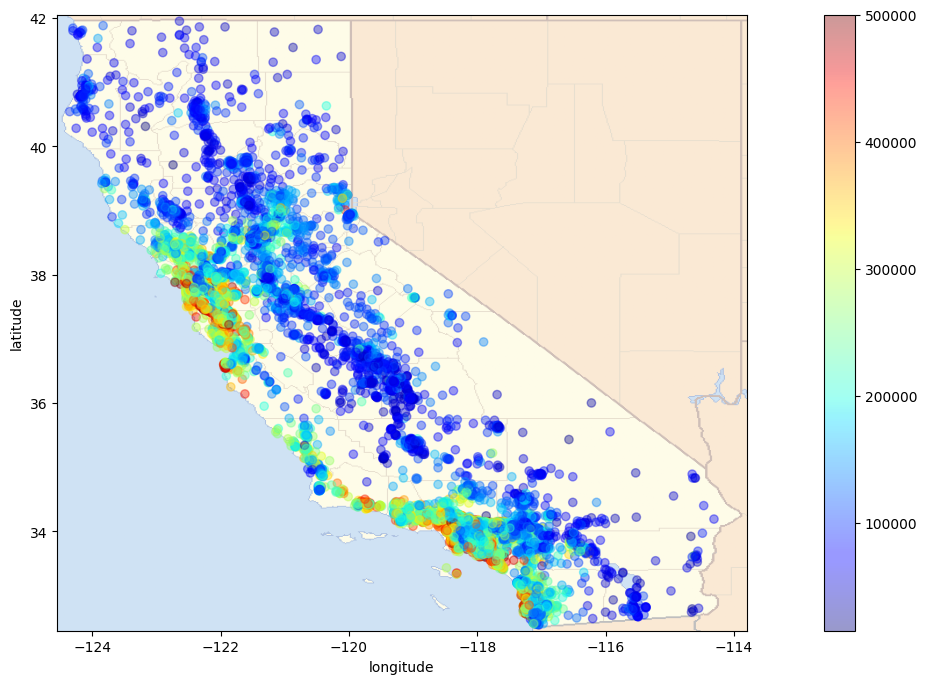

In [55]:
plt.figure(figsize=(20,8))
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel('longitude'); plt.ylabel('latitude')
plt.scatter(df_train['longitude'], df_train['latitude'], marker='o', c=df_train['median_house_value'], cmap='jet', alpha=0.4)
plt.colorbar()

In [56]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder() #sparse=False)
ocean_encoded = onehot_encoder.fit_transform(df_train[['ocean_proximity']])
ocean_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15740 stored elements and shape (15740, 5)>

In [57]:
ocean_encoded.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [58]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
np.c_[ocean_encoded.toarray(), df_train['ocean_proximity']][:10]

array([[0.0, 1.0, 0.0, 0.0, 0.0, 'INLAND'],
       [1.0, 0.0, 0.0, 0.0, 0.0, '<1H OCEAN'],
       [0.0, 0.0, 0.0, 0.0, 1.0, 'NEAR OCEAN'],
       [0.0, 0.0, 0.0, 1.0, 0.0, 'NEAR BAY'],
       [0.0, 1.0, 0.0, 0.0, 0.0, 'INLAND'],
       [0.0, 1.0, 0.0, 0.0, 0.0, 'INLAND'],
       [1.0, 0.0, 0.0, 0.0, 0.0, '<1H OCEAN'],
       [1.0, 0.0, 0.0, 0.0, 0.0, '<1H OCEAN'],
       [1.0, 0.0, 0.0, 0.0, 0.0, '<1H OCEAN'],
       [0.0, 1.0, 0.0, 0.0, 0.0, 'INLAND']], dtype=object)

In [60]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'categoria_col'],
      dtype='object')

In [61]:
from sklearn.compose import make_column_transformer

num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
cat_features = ['ocean_proximity']

preprocess = make_column_transformer(('passthrough', num_features), (OneHotEncoder(), cat_features))

X_train_transformed = preprocess.fit_transform(X_train)
X_train_transformed

array([[-117.42,   34.13,    4.  , ...,    0.  ,    0.  ,    0.  ],
       [-118.  ,   33.81,   17.  , ...,    0.  ,    0.  ,    0.  ],
       [-118.1 ,   33.74,   37.  , ...,    0.  ,    0.  ,    1.  ],
       ...,
       [-118.26,   34.01,   38.  , ...,    0.  ,    0.  ,    0.  ],
       [-122.86,   39.05,   20.  , ...,    0.  ,    0.  ,    0.  ],
       [-117.89,   33.84,   33.  , ...,    0.  ,    0.  ,    0.  ]])

In [62]:
preprocess.transformers_
#preprocess.transformers_[1][1]
#onehot_encoder = preprocess.transformers_[1][1]
#onehot_encoder
#onehot_encoder.get_feature_names_out()

[('passthrough',
  FunctionTransformer(accept_sparse=True, check_inverse=False,
                      feature_names_out='one-to-one'),
  ['longitude',
   'latitude',
   'housing_median_age',
   'total_rooms',
   'total_bedrooms',
   'population',
   'households',
   'median_income']),
 ('onehotencoder', OneHotEncoder(), ['ocean_proximity'])]

In [63]:
features = num_features + list(preprocess.transformers_[1][1].get_feature_names_out())
features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

## Lidando com dados faltantes

In [64]:
df_train.isna().mean()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.009657
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
categoria_col         0.000000
dtype: float64

In [65]:
from sklearn.linear_model import LinearRegression
model = make_pipeline(preprocess, LinearRegression())
#model.fit(X_train, y_train)

**Abordagens mais comuns:**

1. Remover as amostras que contém dados faltantes
1. Remover os atributos que contém dados faltantes
1. Preencher com algum valor pré-definido (*imputar*)

**Observações:**

- Remover atributos é certamente a solução mais simples e é adequada para um desenvolvimento inicial, especialmente se forem poucos atributos removidos. Sempre é possível revisitar essa decisão (de remover ou não um dado atributo) num estágio posterior do desenvolvimento.
- O uso de imputação pode ser útil até mesmo quando não há dados faltantes no conjunto de treinamento, uma vez que dados faltantes podem eventualmente ocorrer quando o modelo for colocado em produção. É bom estar prevenido para essas situações.
- Remover amostras com dados faltantes corresponde a especificar que, na prática, o modelo não poderá realizar predições para amostras que possuem dados faltantes. Mais precisamente, se forem removidas as amostras com dados faltantes do atributo A e nenhuma solução de imputação for utilizada, isso significa exigir que o atributo A seja preenchido antes que o modelo possa realizar predições. Dependendo da aplicação, isso pode ser um modelamento equivocado e limitar severamente o modelo --- ou pode ser exatamente o que se deseja.

(Abordagem avançada: treinar um modelo de aprendizado de máquina para prever os dados faltantes, por exemplo: https://github.com/awslabs/datawig)

In [66]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
bedrooms_imputed = imputer.fit_transform(df_train[['total_bedrooms']])
np.isnan(bedrooms_imputed).mean()

0.0

In [67]:
imputer.statistics_

array([437.])

In [68]:
df_train['total_bedrooms'].median()

437.0

In [69]:
np.unique(bedrooms_imputed[df_train['total_bedrooms'].isna()])

array([437.])

**Obs:** Para dados categóricos com mais de 2 categorias, tipicamente não é necessário usar imputação, pois o dado faltante pode ser tratado como uma categoria adicional:

In [70]:
d = pd.DataFrame(['BLUE', 'RED', 'RED', np.nan, 'GREEN', 'BLUE'], columns=['color'])
print(d)
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(d)
list(onehot_encoder.get_feature_names_out())

   color
0   BLUE
1    RED
2    RED
3    NaN
4  GREEN
5   BLUE


['color_BLUE', 'color_GREEN', 'color_RED', 'color_nan']

In [71]:
preprocess = make_column_transformer(
    (SimpleImputer(strategy='median'), num_features), 
    (OneHotEncoder(), cat_features))

X_train_transformed = preprocess.fit_transform(X_train)
np.isnan(X_train_transformed).mean()

0.0

## Treinamento e avaliação

### Regressão linear

In [72]:
from sklearn.linear_model import LinearRegression

model = make_pipeline(preprocess, LinearRegression())
model.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Test RMSE: {root_mean_squared_error(y_test, model.predict(X_test)):.2f}')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.1%}')

Train RMSE: 61089.56
Train MAPE: 27.5%
 Test RMSE: 60008.48
 Test MAPE: 27.5%


In [73]:
#w = model[-1].coef_

w = model[-1].coef_ * preprocess.transform(X_train).std(axis=0)
w[len(num_features):] = model[-1].coef_[len(num_features):]

print(pd.Series(data=w, index=features)[np.abs(w).argsort()[::-1]])

ocean_proximity_ISLAND        138077.299957
ocean_proximity_INLAND        -63270.849061
median_income                  59709.750235
longitude                     -49053.398210
latitude                      -48337.864272
population                    -34426.830714
ocean_proximity_NEAR BAY      -30237.221156
total_bedrooms                 29911.473205
ocean_proximity_<1H OCEAN     -24773.021918
households                     23226.675546
ocean_proximity_NEAR OCEAN    -19796.207823
total_rooms                   -13692.132508
housing_median_age             11495.758002
dtype: float64


C:\Users\msftr\AppData\Local\Temp\ipykernel_24484\2483614233.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(pd.Series(data=w, index=features)[np.abs(w).argsort()[::-1]])


In [74]:
from scipy import stats
stats.norm.cdf([-0.5, 0.5, -1, 1])

# 1 std moves from percentile 30 to percentile 70
# 2 std moves from percentile 16 to percentile 84

array([0.30853754, 0.69146246, 0.15865525, 0.84134475])

### Atributos polinomiais

In [75]:
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(preprocess, PolynomialFeatures(2, include_bias=False), LinearRegression())
model.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Test RMSE: {root_mean_squared_error(y_test, model.predict(X_test)):.2f}')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.1%}')

Train RMSE: 55132.93
Train MAPE: 24.1%
 Test RMSE: 145280874.43
 Test MAPE: 582.9%


Esse erro de teste absurdamente elevado provavelmente é causado por problemas de multicolinearidade (dependência linear) do atributo categórico com codificação *one-hot*, que se amplificam com a introdução de atributos polinomiais. Uma forma de tentar resolver esse problema é eliminando-se uma das categorias com a opção `drop='first'` no OneHotEncoder.

In [76]:
preprocess_drop = make_column_transformer(
    (SimpleImputer(strategy='median'), num_features), 
    (OneHotEncoder(drop='first'), cat_features))

model = make_pipeline(preprocess_drop, PolynomialFeatures(2, include_bias=False), LinearRegression())
model.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Test RMSE: {root_mean_squared_error(y_test, model.predict(X_test)):.2f}')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.1%}')

Train RMSE: 55132.93
Train MAPE: 24.1%
 Test RMSE: 54895.86
 Test MAPE: 24.4%


### Regularização

Outra estratégia (mais robusta) para resolver o problema de multicolinearidade é aplicar regularização.

In [77]:
from sklearn.linear_model import Ridge

# Note: preprocess without drop='first'
#
#preprocess = make_column_transformer(
#    (SimpleImputer(strategy='median'), num_features), 
#    (OneHotEncoder(), cat_features))

model = make_pipeline(preprocess, PolynomialFeatures(2, include_bias=False), Ridge(1e-4))
model.fit(X_train, y_train)
print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Test RMSE: {root_mean_squared_error(y_test, model.predict(X_test)):.2f}')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.1%}')

Train RMSE: 55133.14
Train MAPE: 24.1%
 Test RMSE: 55022.82
 Test MAPE: 24.4%


C:\Users\msftr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.887e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Uma vez que os atributos tem escalas diferentes, a regularização se torna mais efetiva quando os atributos são normalizados (escalonados).

In [78]:
from sklearn.preprocessing import StandardScaler

model = make_pipeline(preprocess, StandardScaler(), PolynomialFeatures(2, include_bias=False), Ridge(1e-4))
model.fit(X_train, y_train)
print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Test RMSE: {root_mean_squared_error(y_test, model.predict(X_test)):.2f}')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.1%}')

Train RMSE: 55132.93
Train MAPE: 24.1%
 Test RMSE: 54649.08
 Test MAPE: 24.4%


Obs: se desejar escolher o parâmetro de regularização automaticamente, você pode experimentar o modelo `sklearn.linear_model.RidgeCV`

### Transformando a variável alvo

- Definimos previamente que estamos interessados no MAPE como métrica principal de avaliação. No entanto, modelos de regressão são tipicamente treinados usando o MSE como função objetivo.
- Para tentar emular o MAPE usando o MSE, uma estratégia é usar como variável de saída $y$ o **logaritmo** neperiano do preço do imóvel $p$, i.e., $y = \log(p)$. Desta forma, o erro na predição de $y$ será função do erro *relativo* na predição do preço, evitando dar peso excessivo aos preços mais altos. Em particular, quando a função de perda é o erro quadrático, a perda equivale aproximadamente ao quadrado do erro relativo:
    
    $L(y,\hat{y}) = (\hat{y} - y)^2 = (\log(\hat{p}) - \log(p))^2 = (\log(\hat{p}/p))^2 = (\log(1 + (\hat{p}-p)/p))^2 \approx ((\hat{p}-p)/p)^2$

    desde que o erro relativo $(\hat{p}-p)/p$ seja suficientemente pequeno. No entanto, mesmo que a aproximação fosse exata, o MSE sob essa transformação corresponderia à media dos *quadrados* dos erros relativos, o que ainda assim difere da média dos erros relativos (MAPE) por amplificar o peso dos erros relativos mais elevados. Ainda assim, é um melhor substituto (*proxy*) do MAPE do que o MSE original.

In [79]:
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(preprocess, TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))
model.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Test RMSE: {root_mean_squared_error(y_test, model.predict(X_test)):.2f}')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.1%}')

Train RMSE: 66132.90
Train MAPE: 24.7%
 Test RMSE: 65343.99
 Test MAPE: 24.8%


Note que o RMSE aumentou enquanto o MAPE diminuiu.

In [80]:
models = {
    'LR'    : make_pipeline(preprocess, LinearRegression()),
    'LR-TTR': make_pipeline(preprocess, 
                            TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)),
    'Poly-LR'    : make_pipeline(preprocess_drop, PolynomialFeatures(2, include_bias=False), LinearRegression()),
    'Poly-LR-TTR': make_pipeline(preprocess_drop, PolynomialFeatures(2, include_bias=False), 
                                 TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)),
    'Poly-Ridge':     make_pipeline(preprocess, StandardScaler(), PolynomialFeatures(2, include_bias=False), Ridge(1e-4)),
    'Poly-Ridge-TTR': make_pipeline(preprocess, StandardScaler(), PolynomialFeatures(2, include_bias=False), 
                                    TransformedTargetRegressor(Ridge(1e-4), func=np.log, inverse_func=np.exp))
}

results = pd.DataFrame([], columns=['Train RMSE', 'Train MAPE', 'Test RMSE', 'Test MAPE'])
for name, model in models.items():
    for (X, y, subset) in [(X_train, y_train, 'Train'), (X_test, y_test, 'Test')]:
        if subset == 'Train':
            model.fit(X, y)
        for (metric, abbrev) in [(root_mean_squared_error, 'RMSE'), (mean_absolute_percentage_error, 'MAPE')]:
            results.loc[name, f'{subset} {abbrev}'] = metric(y, model.predict(X))
results.style.format({'Train RMSE': '{:.2f}', 'Train MAPE': '{:.1%}', 
                       'Test RMSE': '{:.2f}',  'Test MAPE': '{:.1%}'})

,Train RMSE,Train MAPE,Test RMSE,Test MAPE
LR,61089.56,27.5%,60008.48,27.5%
LR-TTR,66132.90,24.7%,65343.99,24.8%
Poly-LR,55132.93,24.1%,54895.86,24.4%
Poly-LR-TTR,56228.27,22.0%,55631.87,22.1%
Poly-Ridge,55132.93,24.1%,54649.08,24.4%
Poly-Ridge-TTR,56228.27,22.0%,55525.41,22.0%
